In [ ]:
"""
If running in colab, mount (download) repo and work from there to be able to use modules and download dataset(s)

PRE-REQUIREMENT:
- create a github personnal access token (finegrained or not) https://docs.github.com/en/authentication/keeping-your-account-and-data-secure/managing-your-personal-access-tokens#creating-a-fine-grained-personal-access-token
- add it as a secret in colab with name GITHUB_ACCESS_TOKEN https://medium.com/@parthdasawant/how-to-use-secrets-in-google-colab-450c38e3ec75
"""
import os
if os.getenv("COLAB_RELEASE_TAG"): # check if running un Google Collab
  if not os.path.isdir('/content/jan24_supply_chain'): # check if repo already exists
    from google.colab import userdata
    GITHUB_ACCESS_TOKEN = userdata.get('GITHUB_ACCESS_TOKEN') # get personnal access token to github
    !git clone --quiet {'https://' + GITHUB_ACCESS_TOKEN + '@github.com/DataScientest-Studio/jan24_supply_chain.git'} # download repo
  os.chdir('/content/jan24_supply_chain/notebooks') # switch the wordking dir to the repo notebook folder (to emulate running locally to use same relative paths)

# load labelled dataset

In [3]:
import data_loader
data_loader.download_datasets()

Retrieving folder contents


Processing file 14RYhYjk0PQijQNi_IfdM2PmJ-QId4pf9 2.jo(bis)_paires_gpt_prompting.csv
Retrieving folder 162U61EOjKNtCuAlxuuw4rfFK9zkkr2vN chatgpt_labelled_reviews_100
Processing file 16L5uaNwEKB0EHDvy5Zyg7gsFbzITTbII edited.csv
Processing file 16INt021kWNRaHLPln4w0CO_-DtJK1mc1 raw.csv
Processing file 16_TH99Qm55ZXkj6-6KL9VJ75FEicF3_l test.csv
Processing file 16eK60cIAaubxPc5Kr_o3PQZXHDKMdaWF train.csv
Retrieving folder 15A6Ryo2CaeTwNoQGuKoxYoQZNx6Z1N5p chatgpt_labelled_reviews_1000
Processing file 15oR5DO2_dvU8wHkGUW5Am9x-xeOs-bLE edited.csv
Processing file 15zQ1bDsGzJXL-_nkubRV6a3ZYFi1vp4Y raw.csv
Processing file 16o25v9yhmQ61cCZuTu0GfhF7LdAieWxJ test.csv
Processing file 16lMGxJxAMvYmmwjwtX-o1J7D184eCUgV train.csv
Processing file 1sL_XsblcDZlpoPcZwVdev-QCqTHXQg93 processed_dataset.csv
Processing file 1ZkYlnEO2Emc7T4HAqSj8koX3BvS43ylQ test_set_chatgpt_reviews.csv


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=14RYhYjk0PQijQNi_IfdM2PmJ-QId4pf9
To: /Users/gwibaux/Workspaces/jan24_supply_chain/data/2.jo(bis)_paires_gpt_prompting.csv
100%|██████████| 24.7k/24.7k [00:00<00:00, 4.35MB/s]
Downloading...
From: https://drive.google.com/uc?id=16L5uaNwEKB0EHDvy5Zyg7gsFbzITTbII
To: /Users/gwibaux/Workspaces/jan24_supply_chain/data/chatgpt_labelled_reviews_100/edited.csv
100%|██████████| 148k/148k [00:00<00:00, 5.42MB/s]
Downloading...
From: https://drive.google.com/uc?id=16INt021kWNRaHLPln4w0CO_-DtJK1mc1
To: /Users/gwibaux/Workspaces/jan24_supply_chain/data/chatgpt_labelled_reviews_100/raw.csv
100%|██████████| 133k/133k [00:00<00:00, 6.34MB/s]
Downloading...
From: https://drive.google.com/uc?id=16_TH99Qm55ZXkj6-6KL9VJ75FEicF3_l
To: /Users/gwibaux/Workspaces/jan24_supply_chain/data/chatgpt_labelled_reviews_100/test.csv
100%|██████████| 23.8k/23.8k [

,Unnamed: 0,review,chatgpt_label,date,company,month
670,647,Contrefaçon ! Colis confisquer et détruit par ...,Problème avec le produit,2017-02-28,CDiscount,2017-02
748,243,"Bonjour , j’ai commandé 2 paddles a 99€ le der...",Problème de rupture de stock,2022-07-21,CDiscount,2022-07
669,471,"Un service après vente catastrophique , une co...",Problème avec le produit,2017-10-01,CDiscount,2017-10
719,80,Commande passe le 02 décembre avec expédition ...,Problème de livraison,2019-12-10,Fnac,2019-12
759,58,"J’ai acheté un téléphone chez Amazon, il y a e...",Problème avec le produit,2022-07-19,Amazon,2022-07


shape:  (800, 6)
nb of review without label: 0


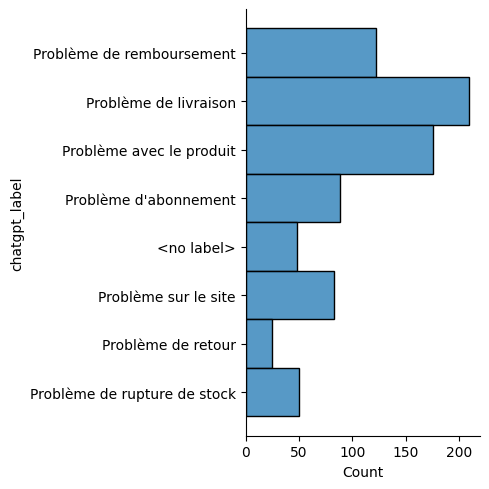

In [4]:
import pandas as pd
from itables import show
import ast
import numpy as np

df = pd.read_csv('../data/chatgpt_labelled_reviews_1000/train.csv') # we load only the train dataset for fine-tuning. We will after fine-tuning on the test one (and do another split for eval at each epoch)

display(df.sample(5))
print('shape: ', df.shape)
print('nb of review without label:', df['chatgpt_label'].isna().sum())

import seaborn as sns
sns.displot(y='chatgpt_label', data=df);

# clusters k-means vs labels

Si nous essayons de faire des clusters avec un modèle pré-entrainé, nous nous rendons compte que cela ne correspond pas du tout aux labels que nous avons par ailleurs.

In [5]:
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer('distilbert-multilingual-nli-stsb-quora-ranking')
#model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

corpus_embeddings = model.encode(df['review'].to_numpy(), convert_to_tensor=True)


# k-means
from sklearn.cluster import KMeans
num_clusters = 7
clustering_model = KMeans(n_clusters=num_clusters)
clustering_model.fit(corpus_embeddings.cpu().numpy())

# Print for all clusters the top_k and bottom top_k elements
top_k=3

km_clustered_sentences = [[] for i in range(num_clusters)]
for sentence_id, cluster_id in enumerate(clustering_model.labels_):
    km_clustered_sentences[cluster_id].append(sentence_id)

for i, cluster in enumerate(km_clustered_sentences):
    print("\nCluster {}, #{} Elements ".format(i + 1, len(cluster)))
    for sentence_id in cluster[0:top_k]:
        print("\t", df['review'].iloc[sentence_id])
    print("\t", "...")
    for sentence_id in cluster[-top_k:]:
        print("\t", df['review'].iloc[sentence_id])

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



Cluster 1, #116 Elements 
	 Il est inacceptable que Amazon annule deux fois mes commandes et réinitialise mes accès sous prétexte d’une tentative de fraude .. Aucune justification les services commerciaux sans responsabilités se cachent derrière la promesse d’un service « spécialisé «  injoignable et qui malgré les promesses ne rappelle pas . J’ai demandé des explications sans réponse des services Amazon impliqués Décevant pour un client depuis 18 ans
	 Privilégier c discount Amazon n'est pas du tout sérieux face à sont concurrent c discount les livraison prime sont déplorable colis perdu ect les remboursement ce fond sous 3 semaine c'est une honte à fuir ! Mérité 0 étoile
	 Malgré un abonnement prime, des produits qui devraient arriver le lendemain ne sont toujours pas là. Impossible de savoir où est le colis ! Le suivi de livraison n'est pas à jour, et quand on contacte Amazon par téléphone ils n'en savent pas davantage. Traçabilité zéro. Le service livraison Amazon Logistics est en

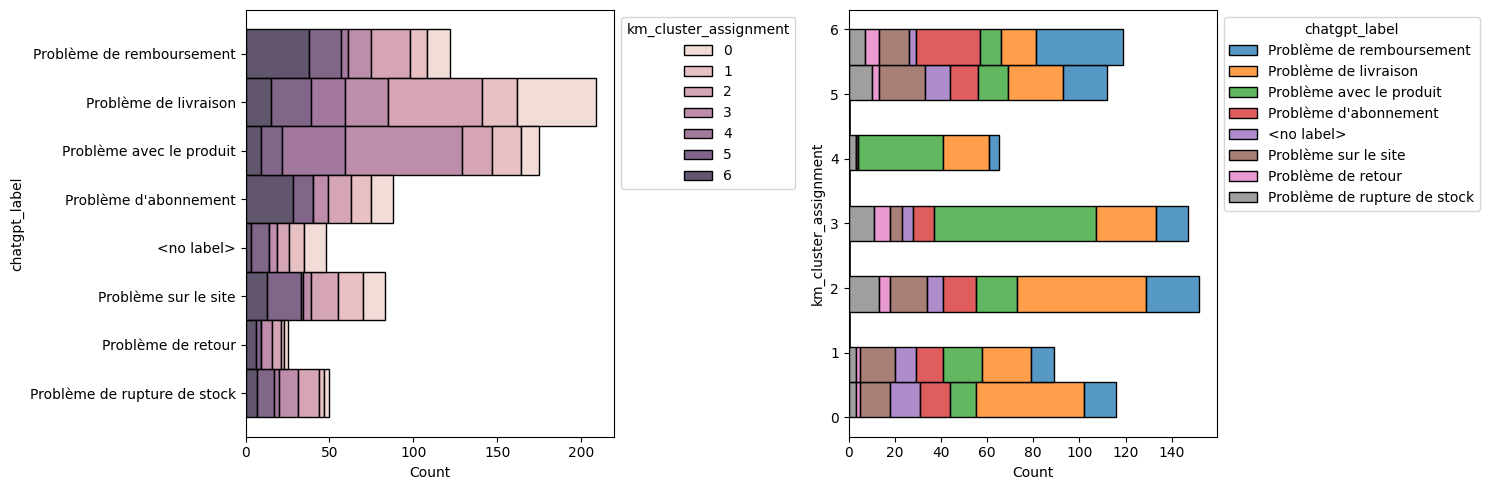

In [6]:
df['km_cluster_assignment'] = clustering_model.labels_

import seaborn as sns
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
sns.histplot(data=df, y='chatgpt_label', hue='km_cluster_assignment', multiple="stack", ax=ax1);
sns.histplot(data=df, y='km_cluster_assignment', hue='chatgpt_label', multiple="stack", ax=ax2);
sns.move_legend(ax1, "upper left", bbox_to_anchor=(1, 1))
sns.move_legend(ax2, "upper left", bbox_to_anchor=(1, 1))
fig.tight_layout()
plt.show()

#sns.displot(data=df, y='chatgpt_label', hue='km_cluster_assignment', palette=palette, multiple="stack")
#sns.displot(data=df, y='km_cluster_assignment', hue='chatgpt_label', palette=palette, multiple="stack")


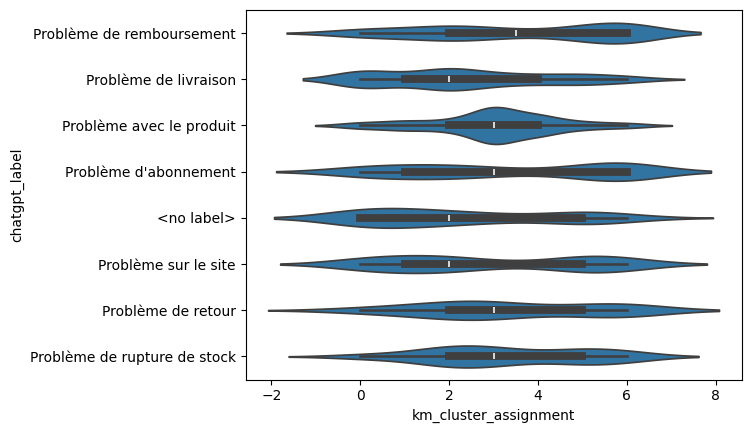

In [7]:
sns.violinplot(data=df, x='km_cluster_assignment', y='chatgpt_label');


In [8]:
# drop k-means clusters as they are unhelpful 
df = df.drop('km_cluster_assignment', axis=1)

In [9]:
# TODO 
# metrics for evaluation of clustering ?

# formatting dataset for fine-tuning

Nous allons donc essayer de fine-tuner le model pour qu'il se rapproche plus de nos labels.
Pour cela nous lui indiquons que les éléments dans la même catégories sont proches, tandis que ceux de deux catégories séparées sont éloignés.
- pairs from the same category : similar --> distance = 0.9
- pairs from different category : disimilar --> distance = 0.1

(le choix de ces chiffres est arbitraire, il faudra garder en tête leur impact et éventuellement les ajuster)

In [10]:
# create unique pairs of reviews

import itertools

print("nb of unique and distinct pairs", (len(df))*(len(df)-1)/2)

pairs = list(itertools.combinations(df.index, 2))
len(pairs) == len(df)*(len(df)-1)/2

pairs = pd.DataFrame(pairs, columns=['key_x','key_y'])
pairs = pairs.merge(df.add_suffix('_x'), left_on="key_x", right_index=True)
pairs = pairs.merge(df.add_suffix('_y'), left_on="key_y", right_index=True)

# add a distance target
pairs['target distance'] = pairs.apply(lambda r : 0.9 if r['chatgpt_label_x']==r['chatgpt_label_y'] else 0.1, axis=1) 

display(pairs.sample(5))
pairs.shape

nb of unique and distinct pairs 319600.0


,key_x,key_y,Unnamed: 0_x,review_x,chatgpt_label_x,date_x,company_x,month_x,Unnamed: 0_y,review_y,chatgpt_label_y,date_y,company_y,month_y,target distance
234681,387,547,620,Fnac hébergeur de vendeur arnaqueur ma fille c...,Problème avec le produit,2020-11-17,Fnac,2020-11,752,"Bonjour. Ai commandé via CDISCOUNT, un casque...",Problème de livraison,2020-01-30,CDiscount,2020-01,0.1
56361,73,736,250,Je depose une plainte pour des chaises toutes ...,Problème avec le produit,2020-07-30,CDiscount,2020-07,600,Après 3 semaines d'attente de livraison de l'a...,Problème de livraison,2020-05-08,Amazon,2020-05,0.1
46038,59,668,5,"J'ai commandé chez eux pour la deuxième fois, ...",Problème avec le produit,2018-03-19,CDiscount,2018-03,62,L’abonnement à l'offre prémium m'a été imposé ...,Problème d'abonnement,2021-01-02,CDiscount,2021-01,0.1
172043,256,396,885,"Seulement 1 articles sur 2 reçu, et le service...",Problème de livraison,2019-12-26,Amazon,2019-12,287,Commande d'un kit piéton vendeur LEADERPROMARK...,Problème de livraison,2017-02-01,CDiscount,2017-02,0.9
85846,115,632,453,A FUIR!!!! Je vous déconseille d'acheter chez ...,<no label>,2018-01-17,Amazon,2018-01,848,"sur 5 articles commandés, 3 reçus soit avec un...",Problème avec le produit,2021-06-18,CDiscount,2021-06,0.1


(319600, 15)

Regardons comment les paires sont vues aujourd'hui par le modèle.

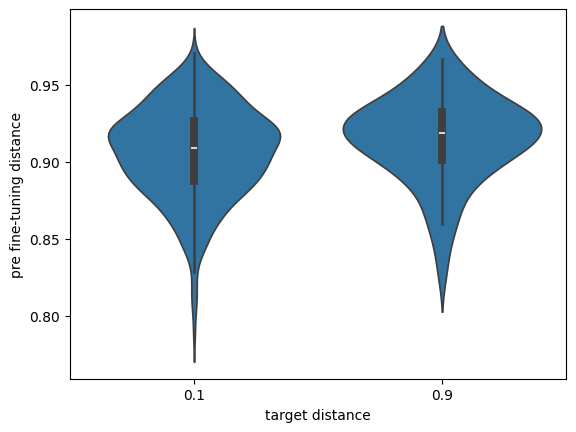

In [11]:
random_state = 42
pairs_sample_size = 800

# keep only a subset of pairs (as we have much more than necessary...)
sampled_pairs = pairs.sample(pairs_sample_size, random_state=random_state)

# compute current distances with the model to compare current state vs our target
sampled_pairs['pre fine-tuning distance'] = sampled_pairs.apply(lambda r: util.cos_sim(model.encode(r['review_x']), model.encode(r['review_y'])).numpy()[0][0] ,axis=1)

#display(sampled_pairs.sample(5))

sns.violinplot(data=sampled_pairs, y='pre fine-tuning distance', x='target distance');


Nous pouvons constater que les commentaires que nous souhaiterions voir plutôt éloignés car dans des catégories différentes (target distance = 0.1), ne le sont à peine plus en moyenne que les commentaires que nous souhaitons voir proche car dans une même catégorie (target distance : 0.9).
Nous allons donc procéder à entrainement du model sur notre jeu de données pour "accentuer" les distances.

# finetuning

In [46]:
force_training = False

# training hyperparams
random_state = 13
pairs_sample_size = 1300 * 10 * 10
test_size=0.2
val_size=0.2

base_model = 'distilbert-multilingual-nli-stsb-quora-ranking'
batch_size = 32
epochs = 7

output_folder = '../models/fine-tuned - train_len={train_len},  pairs_sample_size={pairs_sample_size} - epochs={epochs}, batch_size={batch_size}, base_model={base_model}'.format(
    train_len=len(df),
    pairs_sample_size=pairs_sample_size,
    epochs=epochs,
    batch_size=batch_size,
    base_model=base_model)

from sklearn.model_selection import train_test_split
from sentence_transformers import InputExample, losses, evaluation
from torch.utils.data import DataLoader
from torch.optim import AdamW # souvent utilisé pour l'entraînement des transformers # c'est l'optimizer par défaut
import os, shutil
import time

output_path = os.path.join(os.getcwd(), output_folder)

# load latest training if it exists
if not force_training:
    try:
        fine_tuned_model = SentenceTransformer(output_path)
        print("Loaded latest trained model.")
    except ValueError:
        print("Can't find a saved finetuned model. Launching training...")
        force_training = True

# train it otherwise
if force_training:

    # sample the pairs and split them into a training ,a validationa and a testing datasets
    sampled_pairs = pairs.sample(pairs_sample_size, random_state=random_state)
    X_train, X_test, y_train, y_test = train_test_split(sampled_pairs[['review_x', 'review_y']], sampled_pairs['target distance'], test_size=test_size, random_state=random_state)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, random_state=random_state)
    
    print('training dataset size:', len(X_train))
    print('validation dataset size:', len(X_val))
    print('test dataset size:', len(X_test))
    # TODO do cross-validation instead ?

    # load base model
    fine_tuned_model = SentenceTransformer(base_model)

    # training dataset
    # TODO refactor
    train_examples = []
    for( x, y, target) in zip(X_train['review_x'], X_train['review_y'], y_train):
        example = InputExample(
            texts=[x,y],
            label=target
            )
        train_examples.append(example)
    #train_examples = [InputExample(texts=[row['review_x'], row['review_y']], label=float(row['target distance'])) for index, row in X_train.iterrows()]
        
    train_set = DataLoader(
        train_examples,
        shuffle=True,
        batch_size=batch_size
        )

    # loss
    train_loss = losses.CosineSimilarityLoss(model=fine_tuned_model)

    # validation dataset
    # TODO how to see the loss evolution ? on the training set **and** the validation set ? 
    # reset index of validation set necessary to avoid errors in the training evaluator
    evaluator = evaluation.EmbeddingSimilarityEvaluator(X_val['review_x'].reset_index(drop=True), X_val['review_y'].reset_index(drop=True), y_val.reset_index(drop=True), batch_size=batch_size)

    def print_eval_callback(score, epoch, steps):
        print("epoch {} -  eval cosine_spearman score: {}".format(epoch, score))

    # reset ouput folder
    if os.path.isdir(output_path):
        shutil.rmtree(output_path) 

    # training
    start_time = time.time()

    fine_tuned_model.fit(
        train_objectives=[(train_set, train_loss)],
        evaluator=evaluator,
        callback=print_eval_callback,
        output_path=output_path,
        epochs=epochs, 
        warmup_steps=100
        )

    print("--- training completed in %s seconds ---" % (time.time() - start_time))


Can't find a saved finetuned model. Launching training...
training dataset size: 83200
validation dataset size: 20800
test dataset size: 26000


Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2600 [00:00<?, ?it/s]

epoch 0 -  eval cosine_spearman score: 0.653850788387414


Iteration:   0%|          | 0/2600 [00:00<?, ?it/s]

epoch 1 -  eval cosine_spearman score: 0.6538880739092946


Iteration:   0%|          | 0/2600 [00:00<?, ?it/s]

epoch 2 -  eval cosine_spearman score: 0.653888073901665


Iteration:   0%|          | 0/2600 [00:00<?, ?it/s]

epoch 3 -  eval cosine_spearman score: 0.6538880739088586


Iteration:   0%|          | 0/2600 [00:00<?, ?it/s]

epoch 4 -  eval cosine_spearman score: 0.6538880739114744


Iteration:   0%|          | 0/2600 [00:00<?, ?it/s]

epoch 5 -  eval cosine_spearman score: 0.6538880739084226


Iteration:   0%|          | 0/2600 [00:00<?, ?it/s]

epoch 6 -  eval cosine_spearman score: 0.65388807392063
--- training completed in 34409.658483982086 seconds ---


,epoch,steps,cosine_pearson,cosine_spearman,euclidean_pearson,euclidean_spearman,manhattan_pearson,manhattan_spearman,dot_pearson,dot_spearman
0,0,-1,0.992978,0.653841,0.978596,0.653818,0.985685,0.653851,0.979045,0.653827
1,1,-1,0.996001,0.653888,0.984498,0.653888,0.988508,0.653888,0.990449,0.653888
2,2,-1,0.997439,0.653888,0.985032,0.653888,0.990379,0.653888,0.989394,0.653888
3,3,-1,0.998179,0.653888,0.987065,0.653888,0.991948,0.653888,0.991586,0.653888
4,4,-1,0.998591,0.653888,0.987678,0.653888,0.992721,0.653888,0.991268,0.653888
5,5,-1,0.998546,0.653888,0.988269,0.653888,0.992876,0.653888,0.992065,0.653888
6,6,-1,0.998751,0.653888,0.988509,0.653888,0.993401,0.653888,0.991132,0.653888


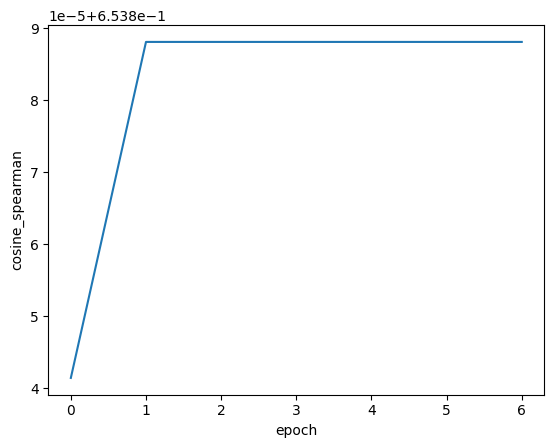

In [47]:
# evals
evals_path = os.path.join(output_path, 'eval/similarity_evaluation_results.csv')
evals_score = pd.read_csv(evals_path)
display(evals_score)

ax = sns.lineplot(data=evals_score, x='epoch', y='cosine_spearman');
ax.set(xticks=evals_score['epoch'])
plt.show();

In [48]:
# compute distance before and after fine-tuning on the test dataset

def plot_distances_before_after(X,y):
    X = X.reset_index(drop=True) # avoid index errors when computing embeddings
    y = y.reset_index(drop=True)

    results = pd.DataFrame()
    results['target distance'] = y
    results['pre fine-tuning distance'] = X.apply(lambda r: util.cos_sim(model.encode(r['review_x']), model.encode(r['review_y'])).numpy()[0][0] ,axis=1)
    results['post fine-tuning distance'] = X.apply(lambda r: util.cos_sim(fine_tuned_model.encode(r['review_x']), fine_tuned_model.encode(r['review_y'])).numpy()[0][0] ,axis=1)
    #display(results)

    # compare model distances to target distances
    sns.violinplot(data=results, y='post fine-tuning distance', x='target distance', label='Post fine-tuning');
    sns.violinplot(data=results, y='pre fine-tuning distance', x='target distance', label='Pre fine-tuning');
    plt.legend();


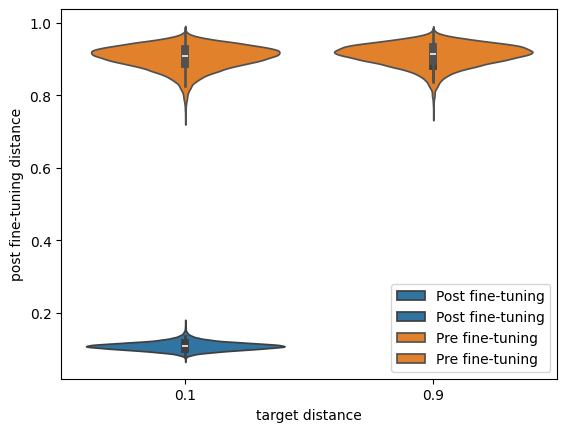

In [49]:
plot_distances_before_after(X_train, y_train)
plt.savefig(output_folder+'/eval/train')

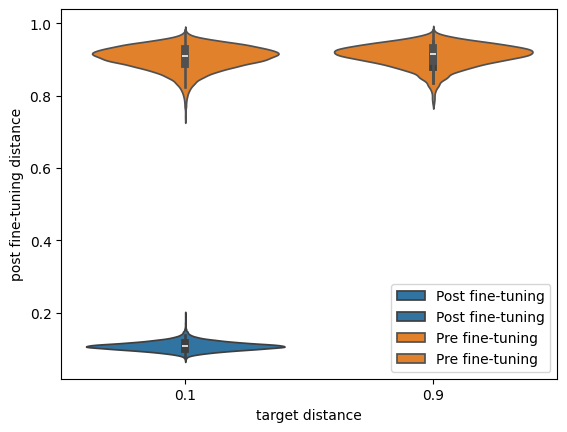

In [50]:
plot_distances_before_after(X_val, y_val)
plt.savefig(output_folder+'/eval/val')

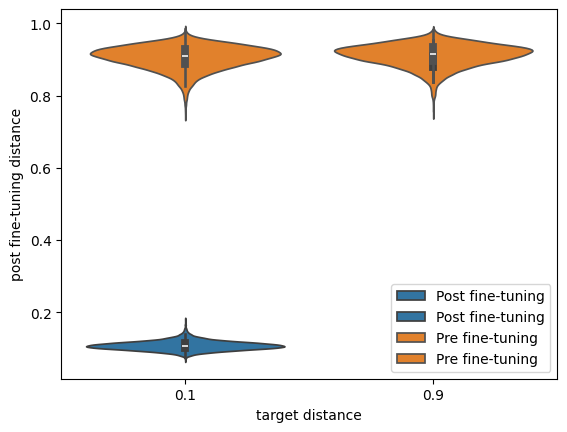

: 

In [51]:
plot_distances_before_after(X_test,y_test)
plt.savefig(output_folder+'/eval/test')